Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

## Lab 10

We will try to formulate this problem as a Markov Decision Process and then use Reinforcement Learning to train an agent into winning Tic-Tac-Toe. I'm going to use some of the code that the professor wrote in class. Since the environment of the agent is not very complez, we are going to opt for model free RL. So we are not looking at anything else other than the reward the agent gets at the end. I was considering using value iteration, but since I don't really know the transition probabilities from one state to another I will use Q-learning instead.

In [357]:
from itertools import combinations
from collections import namedtuple, defaultdict, Counter
from random import choice, randrange, random
from copy import deepcopy
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import numpy as np

In [358]:
State = namedtuple('State', ['x', 'o'])

In [359]:
class Agent:
    def __init__(self, Q_table: defaultdict[defaultdict[float]], lr: float, epsilon: float, dr: float, type: str):
        self.Q_table = Q_table
        self.lr = lr
        self.epsilon = epsilon
        self.dr = dr
        self.type = type

    def update_Q_table(self, state: State(set, set), action: int, next_state: State(set, set), available: set, reward: int):

        hashable_state = (frozenset(state.x), frozenset(state.o))
        hashable_next_state = (frozenset(next_state.x), frozenset(next_state.o))

        next_sa_values = [self.Q_table[hashable_next_state][next_action] for next_action in available]
        max_next = max(next_sa_values) if next_sa_values else 0.0
        # here I'm using the bellman equation:
        # Q(s, a) = Q(s, a) + lr * (r + dr*max_a(Q(s',a')) - Q(s,a))
        self.Q_table[hashable_state][action] += self.lr * (reward + self.dr*max_next - self.Q_table[hashable_state][action])

    def pick_action(self, available: set, state: State(set, set)):

        state = (frozenset(state.x), frozenset(state.o))

        best_action = choice(list(available))

        if random() < self.epsilon:
            return best_action
        
        best_action_value = self.Q_table[state][best_action]

        available.remove(best_action)

        if available:
            for action in available:
                action_value = self.Q_table[state][action]
                if action_value > best_action_value:
                    best_action = action
                    best_action_value = action_value
        
        return best_action

In [360]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [361]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [362]:
def win(elements):
    """Checks is elements is winning"""
    return any(sum(c) == 15 for c in combinations(elements, 3))

def evaluate_state(pos: State):
    """Evaluate state: +1 first player wins"""
    if win(pos.x):
        return 1
    elif win(pos.o):
        return -1
    else:
        return 0

In [363]:
def play_game(agent1: Agent, agent2: Agent):
    x_trajectory = list()
    o_trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    last_state = None
    num_ply = 0
    while available:

        if num_ply != 0:
            agent1.update_Q_table(current_state_x, action_x, deepcopy(state), deepcopy(available), 0)
        
        action_x = agent1.pick_action(deepcopy(available), state)
        current_state_x = deepcopy(state)
        x_trajectory.append((current_state_x, action_x))
        available.remove(action_x)
        state.x.add(action_x)
        
        if not available:
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], 0)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], 0.5)
            break
        if win(state.x):
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], 1)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], -1)
            break

        if num_ply != 0:
            agent2.update_Q_table(current_state_o, action_o, deepcopy(state), deepcopy(available), 0)

        action_o = agent2.pick_action(deepcopy(available), state)
        current_state_o = deepcopy(state)
        o_trajectory.append((current_state_o, action_o))
        available.remove(action_o)
        state.o.add(action_o)

        if win(state.o):
            last_state = deepcopy(state)
            agent1.update_Q_table(current_state_x, action_x, last_state, [], -1)
            agent2.update_Q_table(current_state_o, action_o, last_state, [], 1)
            break

        num_ply += 1
    
    return last_state # list of (state, action) pairs

In [364]:
def train(agent1: Agent, agent2: Agent, num_games: int):

    performance_check = dict()

    for steps in tqdm(range(num_games)):
        last_state = play_game(agent1, agent2)
        assert last_state != None

        if steps % (num_games / 100) == 0:
            
            win_record = []
            best_agent = Agent(agent1.Q_table, lr=0, epsilon=0, dr=0, type='x')
            random_agent = Agent(agent2.Q_table, lr=0, epsilon=1, dr=0, type='o')

            for i in range(1000):
                last_state = play_game(best_agent, random_agent)
                winner = evaluate_state(last_state)
                win_record.append(winner)

            performance_check[steps] = Counter(win_record)
    
    return performance_check

In [365]:
Q_table = defaultdict(lambda: defaultdict(lambda: random()))
hit_state = defaultdict(int)

EPSILON = 1 # Chance of choosing random move instead of best move
LEARNING_RATE = 0.1
DISCOUNT_RATE = 1.0


agent1 = Agent(Q_table, lr=LEARNING_RATE, epsilon=EPSILON, dr=DISCOUNT_RATE, type='x')
agent2 = Agent(Q_table, lr=LEARNING_RATE, epsilon=1, dr=DISCOUNT_RATE, type='o')

training_stats = train(agent1, agent2, 100_000)

100%|██████████| 100000/100000 [01:12<00:00, 1383.40it/s]


In [366]:
print(training_stats)

{0: Counter({1: 649, -1: 206, 0: 145}), 1000: Counter({1: 560, -1: 326, 0: 114}), 2000: Counter({1: 588, -1: 311, 0: 101}), 3000: Counter({1: 620, -1: 294, 0: 86}), 4000: Counter({1: 600, -1: 294, 0: 106}), 5000: Counter({1: 595, -1: 274, 0: 131}), 6000: Counter({1: 688, -1: 211, 0: 101}), 7000: Counter({1: 600, -1: 273, 0: 127}), 8000: Counter({1: 572, -1: 273, 0: 155}), 9000: Counter({1: 623, -1: 278, 0: 99}), 10000: Counter({1: 579, -1: 267, 0: 154}), 11000: Counter({1: 700, -1: 163, 0: 137}), 12000: Counter({1: 711, -1: 150, 0: 139}), 13000: Counter({1: 705, -1: 163, 0: 132}), 14000: Counter({1: 713, -1: 165, 0: 122}), 15000: Counter({1: 775, -1: 146, 0: 79}), 16000: Counter({1: 779, -1: 123, 0: 98}), 17000: Counter({1: 768, -1: 155, 0: 77}), 18000: Counter({1: 702, 0: 156, -1: 142}), 19000: Counter({1: 912, 0: 55, -1: 33}), 20000: Counter({1: 814, -1: 123, 0: 63}), 21000: Counter({1: 800, -1: 107, 0: 93}), 22000: Counter({1: 888, 0: 85, -1: 27}), 23000: Counter({1: 910, 0: 49, -1:

Text(0.5, 1.0, 'Number of games lost (out of 1000)')

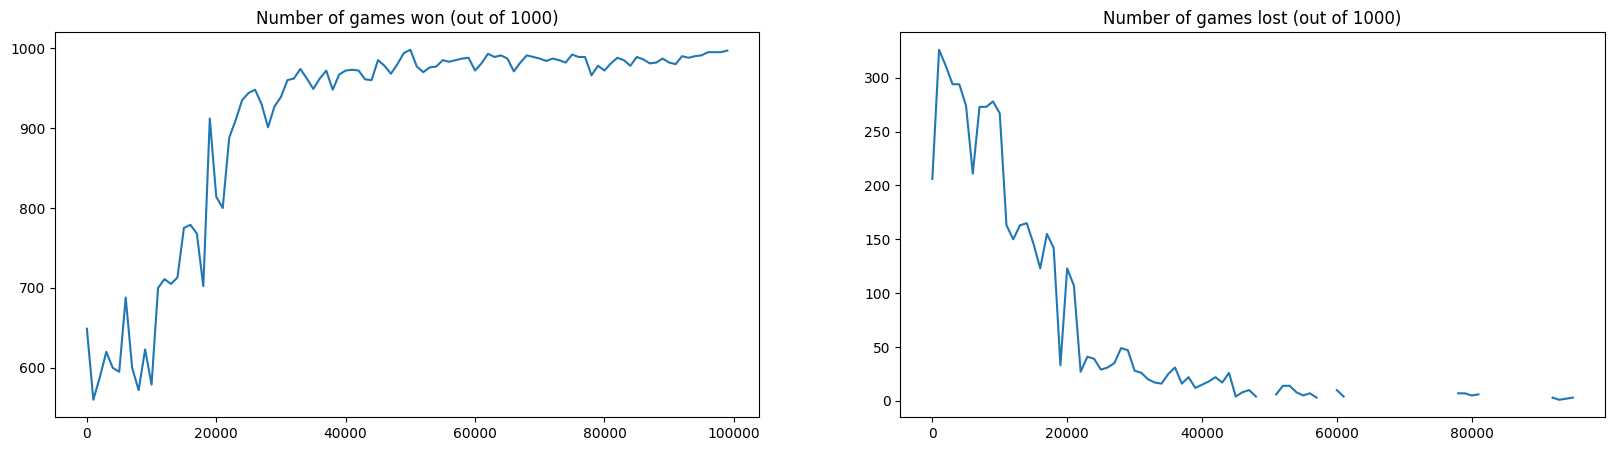

In [381]:
fig, (ax_won, ax_lost) = plt.subplots(1, 2, figsize=(20, 5))

y_won = []

y_lost = []

x = []


for i, win_record in training_stats.items():
    x.append(i)
    y_won.append(win_record.get(1))
    y_lost.append(win_record.get(-1))

ax_won.plot(np.array(x), np.array(y_won))
ax_won.set_title("Number of games won (out of 1000)")


ax_lost.plot(np.array(x), np.array(y_lost))
ax_lost.set_title("Number of games lost (out of 1000)")


In [370]:
# Here I'm training my agent against an already trained agent, making it more difficult to win

trained_agent1 = Agent(agent1.Q_table, lr=0.1, epsilon=0.1, dr=0.9, type='x')
trained_agent2 = Agent(agent2.Q_table, lr=0.1, epsilon=0.1, dr=0.9, type='o')

new_training_stats = train(trained_agent1, trained_agent2, 100_000)

100%|██████████| 100000/100000 [01:13<00:00, 1357.34it/s]


Text(0.5, 1.0, 'Number of games lost (out of 1000)')

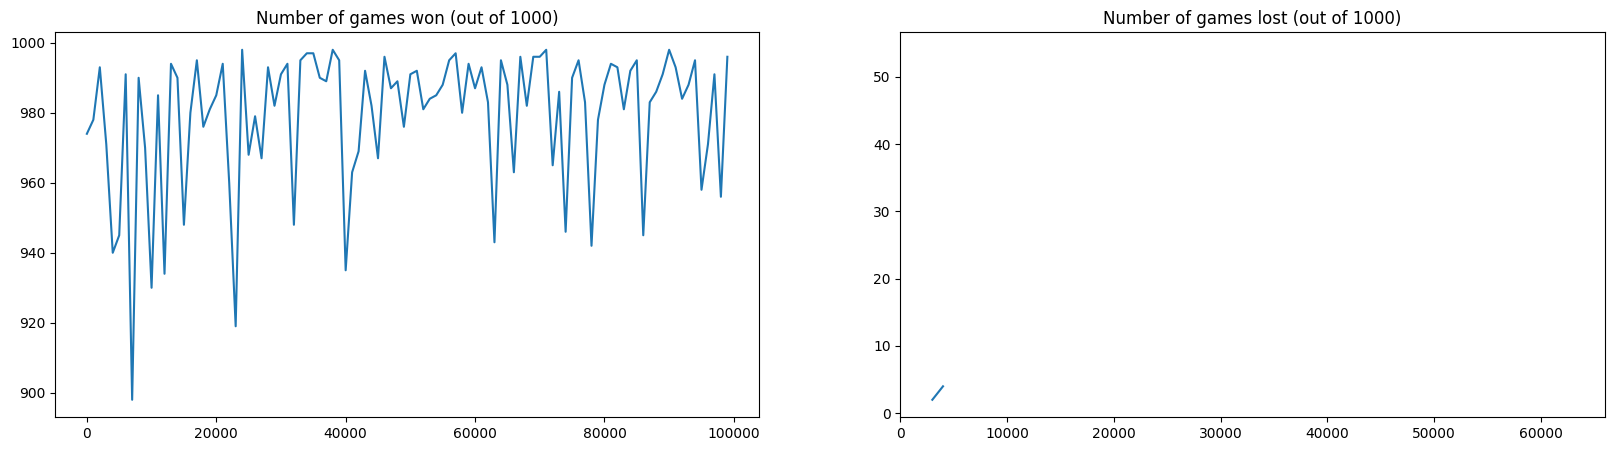

In [383]:
fig, (ax_won, ax_lost) = plt.subplots(1, 2, figsize=(20, 5))

y_won = []

y_lost = []

x = []


for i, win_record in new_training_stats.items():
    x.append(i)
    y_won.append(win_record.get(1))
    y_lost.append(win_record.get(-1))

ax_won.plot(np.array(x), np.array(y_won))
ax_won.set_title("Number of games won (out of 1000)")

ax_lost.plot(np.array(x), np.array(y_lost))
ax_lost.set_title("Number of games lost (out of 1000)")